In [1]:
!pip install transformers pandas openpyxl scikit-learn matplotlib seaborn

In [2]:
from google.colab import files
uploaded = files.upload()

Saving break_freeze_for_polysemy profiling.xlsx to break_freeze_for_polysemy profiling.xlsx


In [3]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [4]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
model.eval()

# 엑셀 파일 로드
filename = [f for f in uploaded if f.endswith(".xlsx")][0]
df = pd.read_excel(filename)

sentences = df.iloc[:, 2]  # C열: 문장
syntaxes = df.iloc[:, 3]   # D열: 구문
labels = df.iloc[:, 5]     # F열: 의미
concreteness = df.iloc[:, 6]     # G열: 대상의 구체성
animacy = df.iloc[:, 7]     # H열: 대상의 유생성
intentionality = df.iloc[:, 8]     # I열: 사동주의 의도성
identifiability = df.iloc[:, 9]     # J열: 사동주의 식별가능성

keywords = ['break', 'broke', 'broken', 'breaking', 'freeze', 'froze', 'frozen', 'freezing']

def extract_token_embedding(sentence, keywords):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    match_indices = [i for i, t in enumerate(tokens) if any(kw in t for kw in keywords)]
    if not match_indices:
        return None
    return outputs.last_hidden_state[0][match_indices[0]].numpy()

embeddings, valid_labels, valid_syntaxes, valid_sentences, valid_concreteness, valid_animacy, valid_intentionality, valid_identifiability = [], [], [], [], [], [], [], []

for sent, syn, label, concret, anim, intent, ident in tqdm(zip(sentences, syntaxes, labels, concreteness, animacy, intentionality, identifiability), total=len(sentences)):
    vec = extract_token_embedding(str(sent), keywords)
    if vec is not None:
        embeddings.append(vec)
        valid_labels.append(label)
        valid_syntaxes.append(syn)
        valid_sentences.append(sent)
        valid_concreteness.append(concret)
        valid_animacy.append(anim)
        valid_intentionality.append(intent)
        valid_identifiability.append(ident)

# 저장
embedding_df = pd.DataFrame(embeddings)
embedding_df['sense'] = valid_labels
embedding_df['syntax'] = valid_syntaxes
embedding_df['sentence'] = valid_sentences
embedding_df['concreteness'] = valid_concreteness
embedding_df['animacy'] = valid_animacy
embedding_df['intentionality'] = valid_intentionality
embedding_df['identifiability'] = valid_identifiability
embedding_df.to_csv("bert_embeddings_with_roles.csv", index=False)

from google.colab import files
files.download("bert_embeddings_with_roles.csv")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 1060/1060 [02:29<00:00,  7.08it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
from google.colab import files
uploaded = files.upload()

Saving bert_embeddings_with_roles.csv to bert_embeddings_with_roles (1).csv


In [6]:
# 📄 데이터 로드 (sense + syntax + sentence + role 정보가 포함된 CSV)
filename = list(uploaded.keys())[0]
# Try reading with 'utf-8' encoding first
try:
    df = pd.read_csv(filename, encoding='utf-8')
except UnicodeDecodeError:
    # If 'utf-8' fails, try 'cp949' or 'latin-1'
    try:
        df = pd.read_csv(filename, encoding='cp949')
    except UnicodeDecodeError:
        df = pd.read_csv(filename, encoding='latin-1')
# Specify 'euc-kr' encoding

In [7]:
# 🧠 전처리: 동사 태깅 (break vs freeze)
df["verb"] = df["sense"].apply(lambda x: "break" if "break" in str(x).lower() else (
                                          "freeze" if "freeze" in str(x).lower() else "unknown"))

In [8]:
### 추가 (verb - sense 수동 mapping) ###

# Step 1: sense-to-verb 딕셔너리 정의
sense_to_verb = {
    # break senses
    'destruction': 'break',
    'bodily harm': 'break',
    'EPS breakdown': 'break',
    'decoding': 'break',
    'disclosure': 'break',
    'emergence': 'break',
    'violation': 'break',
    'breakthrough': 'break',
    'interruption': 'break',
    'termination': 'break',
    'change': 'break',

    # freeze senses
    'physical freezing': 'freeze',
    'bodily freezing': 'freeze',
    'natural freezing': 'freeze',
    'preservation': 'freeze',
    'immobilization': 'freeze',
    'immobilization_mechanical': 'freeze',
    'immobilization_tech': 'freeze',
    'emotional/mental freezing': 'freeze',
    'economical freezing': 'freeze',
    'suspension': 'freeze',
}

# Step 2: verb 컬럼 생성
df['verb'] = df['sense'].map(sense_to_verb).fillna('unknown')

In [9]:
print(df)

             0         1         2         3         4         5         6  \
0    -0.268296  0.515551 -0.036982  0.167487  0.746249 -0.043273  0.287072   
1     0.279772  0.427525  0.143629  0.469398  0.902734 -0.045868 -0.058215   
2    -0.020743  0.409262  0.079372  1.068581  1.152672 -0.147916  0.561047   
3    -0.080312  0.102309 -0.114360  0.708209  0.477703 -0.529139  0.313383   
4    -0.194344  0.342621  0.341211  0.876533  0.969503 -0.255095  0.202830   
...        ...       ...       ...       ...       ...       ...       ...   
1055  0.759600  0.166568  0.288335  0.212423  1.088400  0.094661  0.476108   
1056  0.968607  0.882646 -0.076489 -0.195994 -0.038850 -0.172950  0.069940   
1057  1.087639  0.327397  0.624524  0.081620  0.547899  0.134391  0.449261   
1058  0.080907  0.769552 -0.106087  0.072690 -0.025398 -0.181115  0.234857   
1059  0.866261  0.411507 -1.147922  0.276137 -0.275189 -0.422593  0.360351   

             7         8         9  ...       766       767  \


In [10]:
verbs_to_analyze = ["break", "freeze"]


🔍 Analyzing verb: break


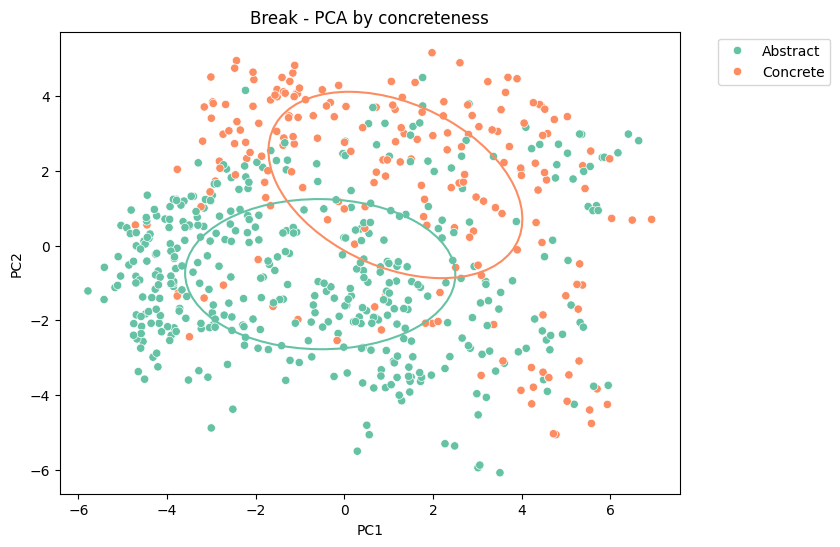

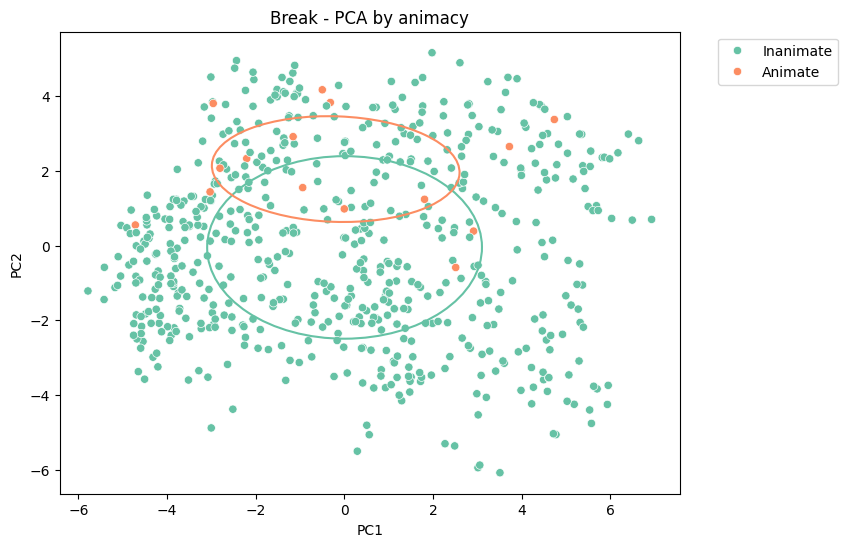

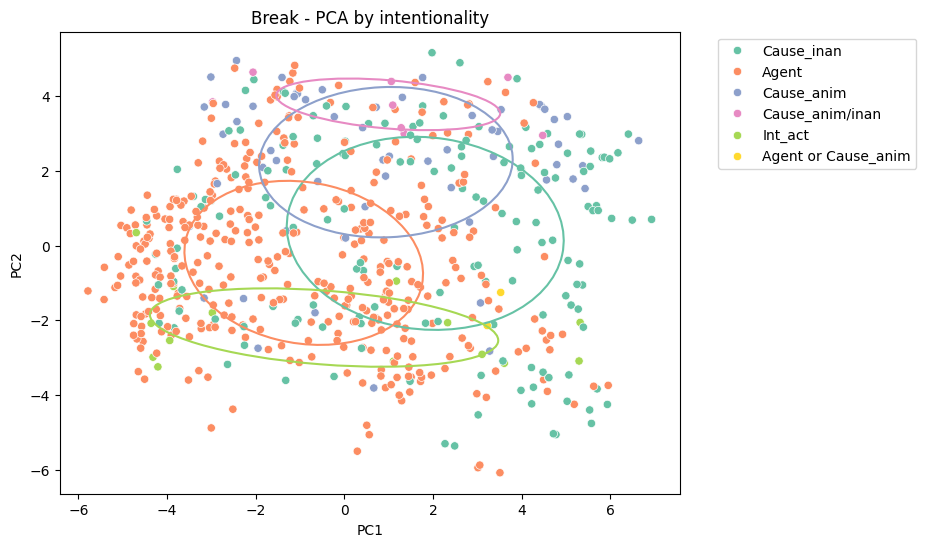

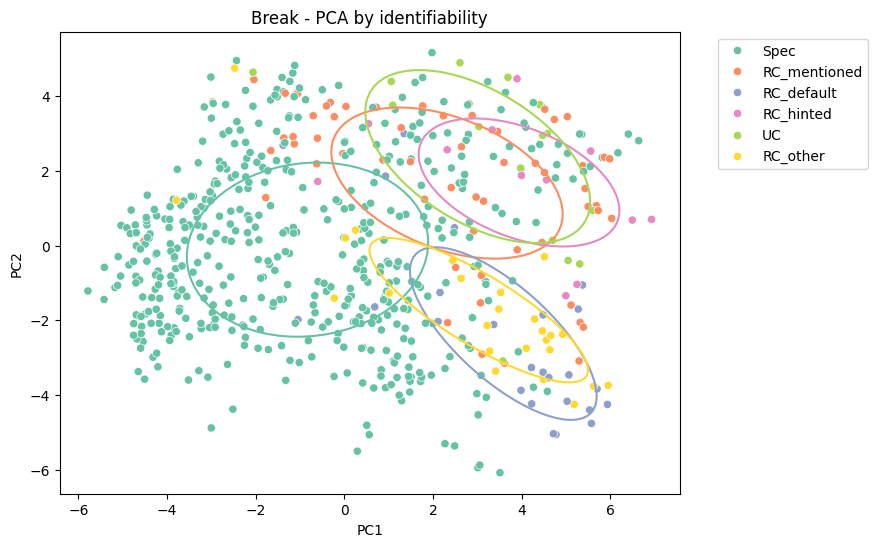


🔍 Analyzing verb: freeze


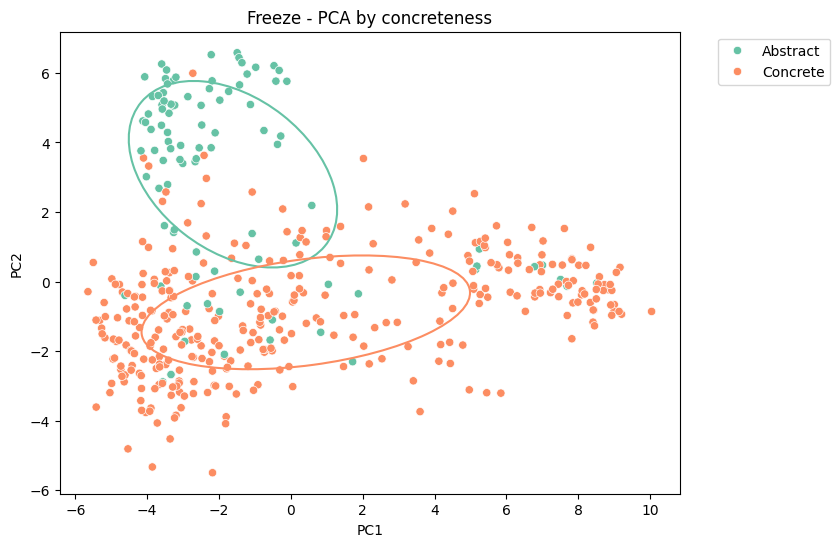

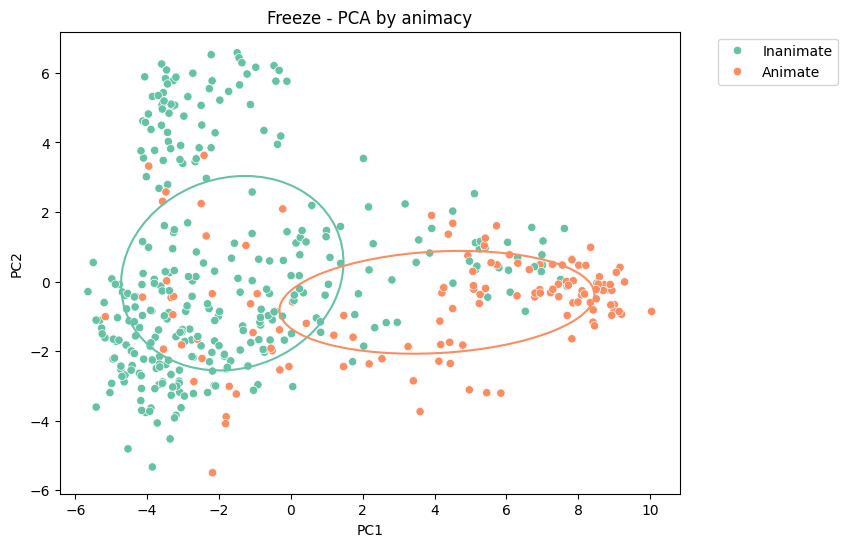

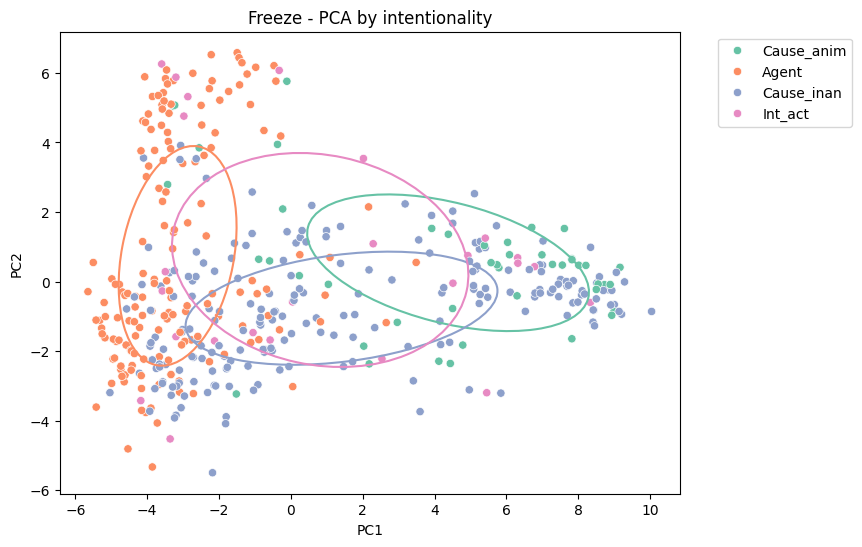

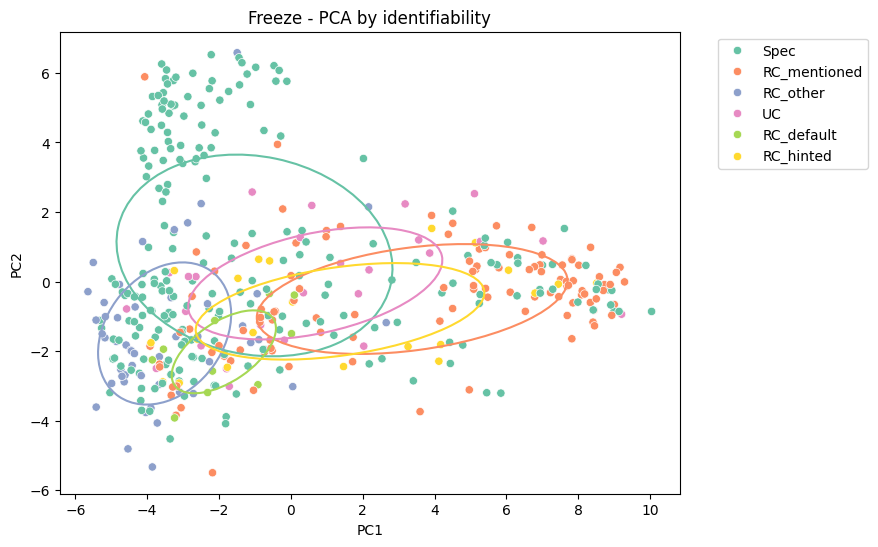

In [11]:
# 🔁 동사별 PCA 수행
for verb in verbs_to_analyze:
    print(f"\n🔍 Analyzing verb: {verb}")
    sub_df = df[df['verb'] == verb].copy()

    # 임베딩만 추출
    X = sub_df.loc[:, '0':'767'].values
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X)
    sub_df['PC1'], sub_df['PC2'] = pca_result[:, 0], pca_result[:, 1]

    # break 동사의 경우 Caus가 왼쪽에, NCaus가 오른쪽에 오도록 PC1 축을 조정
    if verb == 'break':
        caus_mean_pc1 = sub_df[sub_df['syntax'] == 'Caus']['PC1'].mean()
        ncaus_mean_pc1 = sub_df[sub_df['syntax'] == 'NCaus']['PC1'].mean()
        if caus_mean_pc1 > ncaus_mean_pc1:
            sub_df['PC1'] = -sub_df['PC1']


    # === sense/syntax 대신 G~J 열 반복 ===
    features_to_plot = [
        "concreteness", "animacy",
        "intentionality", "identifiability"
    ]

    for feature in features_to_plot:
        plt.figure(figsize=(8,6))
        plot = sns.scatterplot(x='PC1', y='PC2', hue=sub_df[feature], palette='Set2', data=sub_df)

        # Get the handles and labels from the legend
        handles, labels = plot.get_legend_handles_labels()

        # Create a dictionary to map labels to colors
        color_map = {}
        for label, handle in zip(labels, handles):
            if hasattr(handle, 'get_facecolor'):
                color_map[label] = handle.get_facecolor()[0]
            else:
                color_map[label] = handle.get_color()

        # 타원 추가
        for label in sub_df[feature].unique():
            subset = sub_df[sub_df[feature] == label]
            if len(subset) > 2:
                cov = np.cov(subset[['PC1','PC2']].T)
                eigvals, eigvecs = np.linalg.eigh(cov)
                order = eigvals.argsort()[::-1]
                eigvals, eigvecs = eigvals[order], eigvecs[:, order]
                angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
                width, height = 2 * np.sqrt(eigvals)
                ellipse = Ellipse((subset['PC1'].mean(), subset['PC2'].mean()),
                                  width, height, angle=angle, edgecolor=color_map[label], facecolor='none', lw=1.5)
                plt.gca().add_patch(ellipse)

        plt.title(f"{verb.capitalize()} - PCA by {feature}")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

# Task
Modify the Python code in the Jupyter Notebook located at "/mnt/data/meaning-in-motion-main/notebooks/03_meaning_representation.ipynb".

First, in cell 4, ensure that the newly added columns 'G', 'H', 'I', and 'J' in the Excel file loading section are correctly propagated to the `extract_token_embedding` function definition and the `embedding_df[...]` creation in the saving section.

Second, update the visualization code in the last cell to generate a series of 15 PCA plots. These plots should highlight specific sense embeddings for the verbs "break" and "freeze" while displaying all other senses in a light gray color. The plots should be grouped as follows, with each group plotted against "concreteness", "intentionality", and "identifiability":

1.  **Break**: 'emergence' and 'disclosure' senses.
2.  **Break**: 'decoding', 'breakthrough', 'interruption', 'termination', and 'violation' senses.
3.  **Break**: 'bodily harm', 'destruction', 'EPS breakdown', and 'change' senses.
4.  **Freeze**: 'preservation', 'economical freezing', and 'suspension' senses.
5.  **Freeze**: The remaining 7 senses ('fixation', 'cessation', 'social freezing', 'shock', 'immobilization', 'solidification', 'death').

Maintain the existing plot styling, axes, and overall appearance from the original code.

## Define sense groups

### Subtask:
Create lists of senses for each of the five plot groups as specified in the task.


**Reasoning**:
The subtask requires creating several lists of sense strings and a list of features for plotting. This can be done in a single code block.



In [14]:
break_group_1 = ['emergence', 'disclosure']
break_group_2 = ['decoding', 'breakthrough', 'interruption', 'termination', 'violation']
break_group_3 = ['bodily harm', 'destruction', 'EPS_breakdown', 'change']
freeze_group_1 = ['preservation', 'economical freezing', 'suspension']
# Updated freeze_group_2 based on user's request
freeze_group_2 = ['bodily freezing', 'physical freezing', 'natural freezing', 'emotional/mental freezing', 'immobilization', 'immobilization_tech', 'immobilization_mechanical']

sense_groups = [
    break_group_1,
    break_group_2,
    break_group_3,
    freeze_group_1,
    freeze_group_2
]

features_to_plot = ["concreteness", "intentionality", "identifiability"]

## Filter and plot

### Subtask:
Generate PCA plots for each sense group, highlighting the selected senses and displaying other senses in gray.


**Reasoning**:
Iterate through sense groups, perform PCA for the corresponding verb, and plot PCA results for each feature, highlighting the senses in the current group and graying out others.




🔍 Analyzing verb: break, senses: ['emergence', 'disclosure']


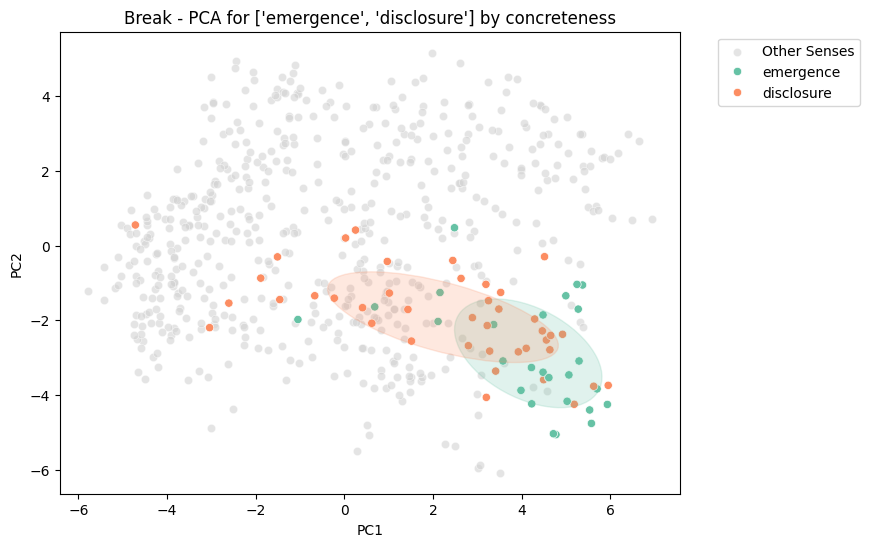

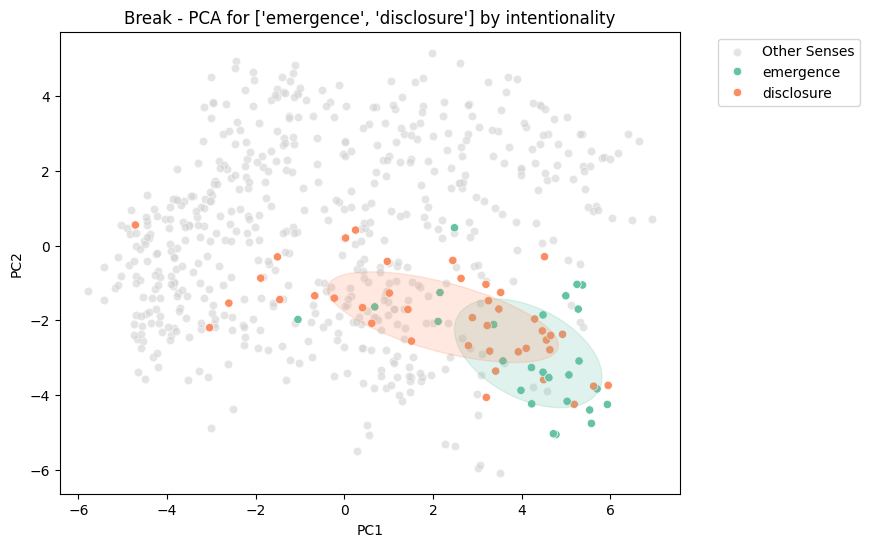

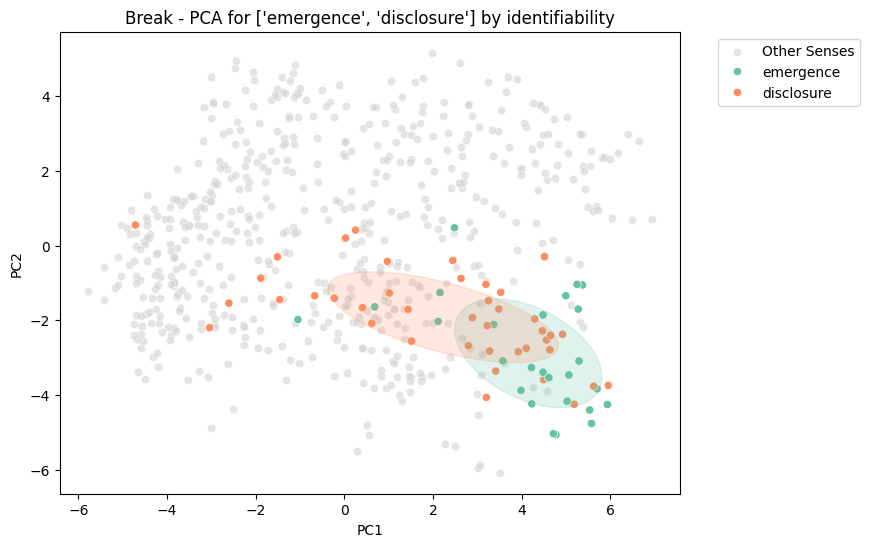


🔍 Analyzing verb: break, senses: ['decoding', 'breakthrough', 'interruption', 'termination', 'violation']


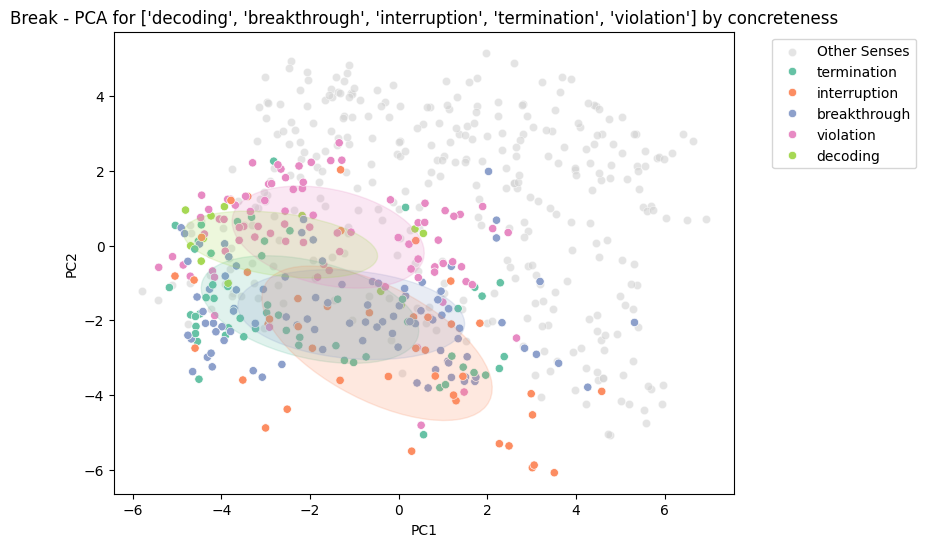

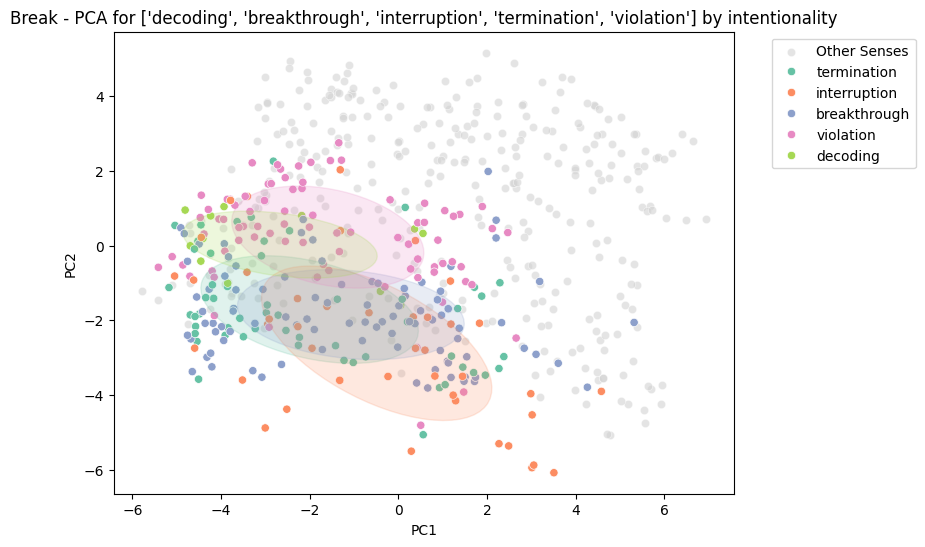

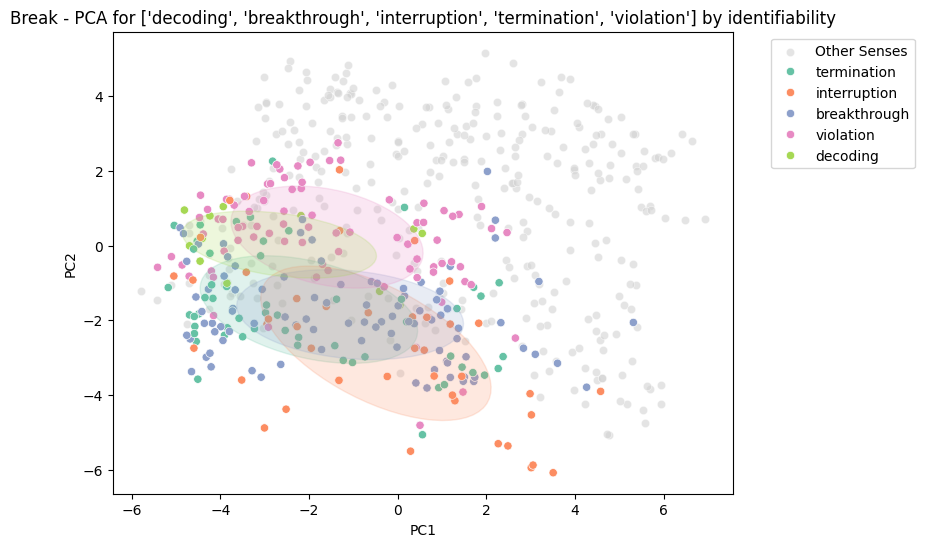


🔍 Analyzing verb: break, senses: ['bodily harm', 'destruction', 'EPS_breakdown', 'change']


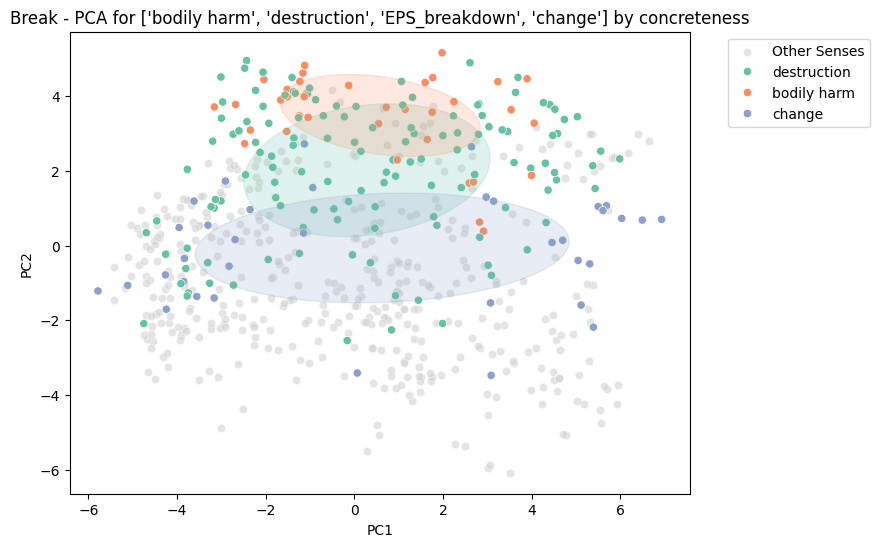

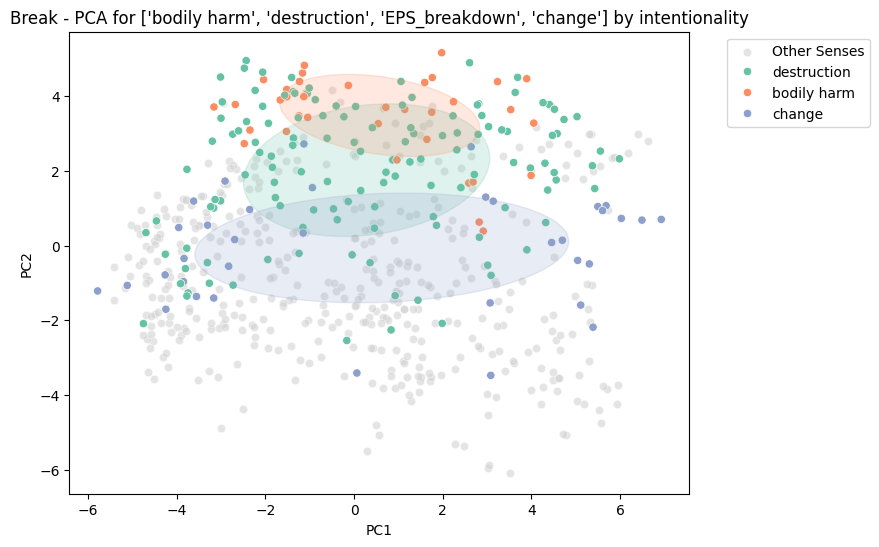

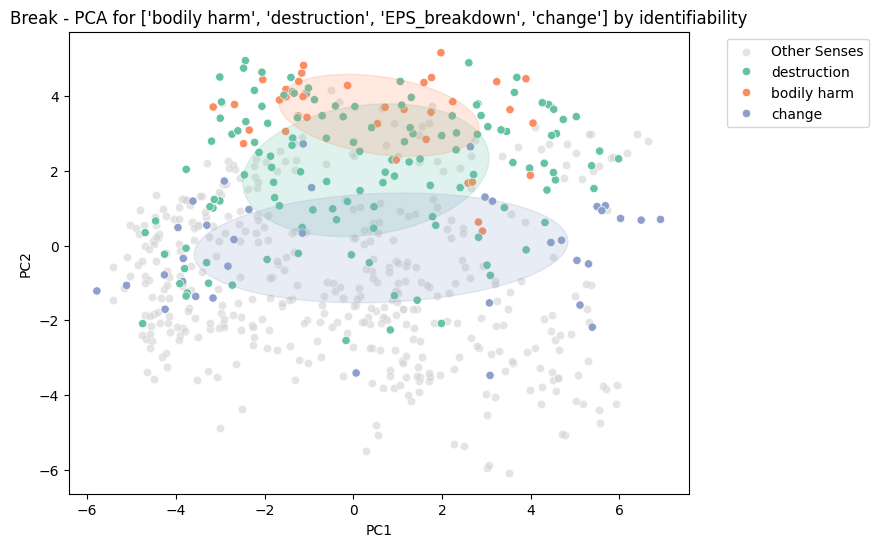


🔍 Analyzing verb: freeze, senses: ['preservation', 'economical freezing', 'suspension']


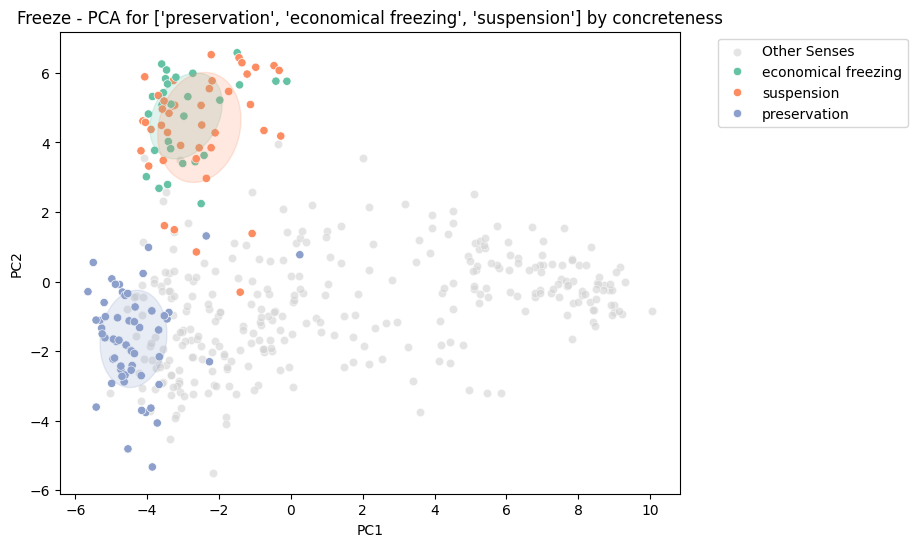

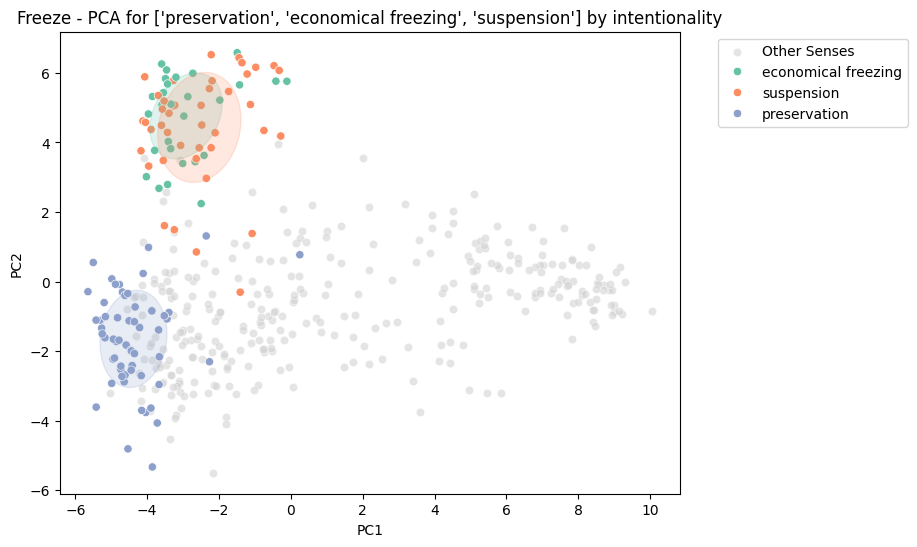

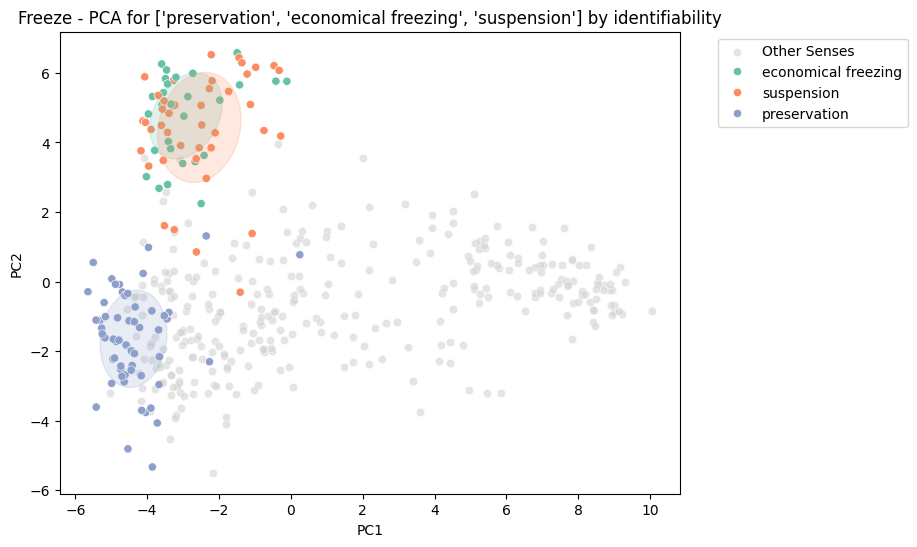


🔍 Analyzing verb: freeze, senses: ['bodily freezing', 'physical freezing', 'natural freezing', 'emotional/mental freezing', 'immobilization', 'immobilization_tech', 'immobilization_mechanical']


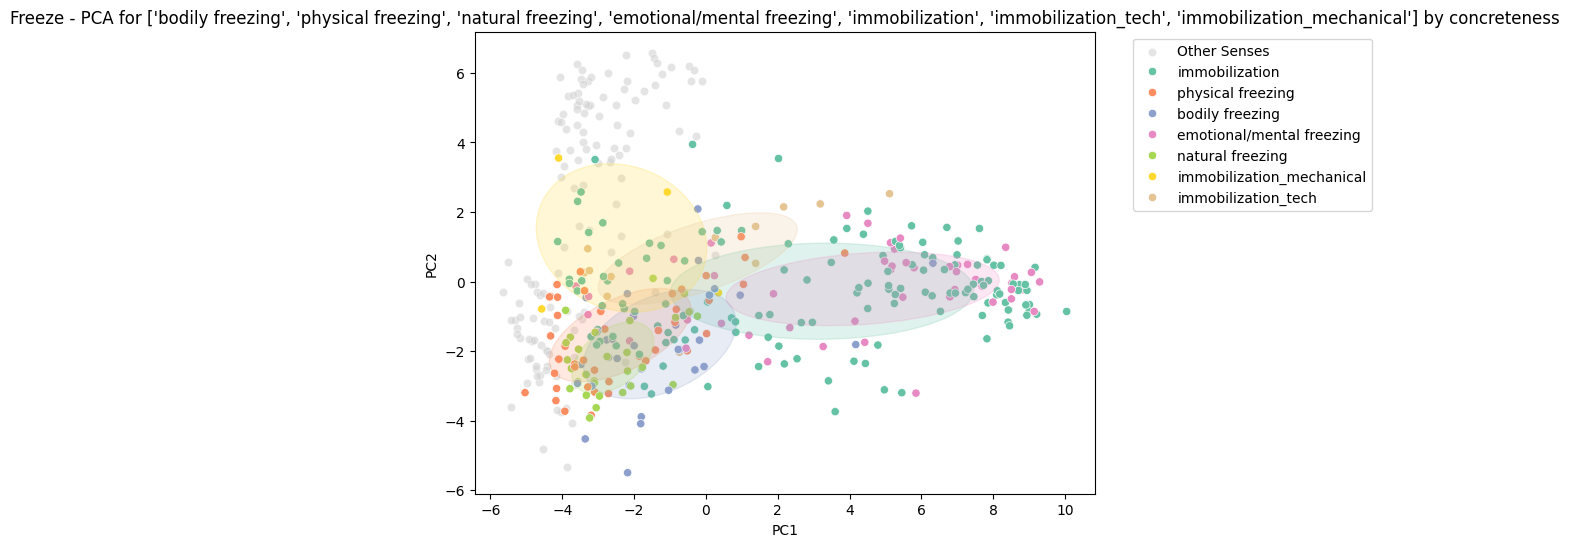

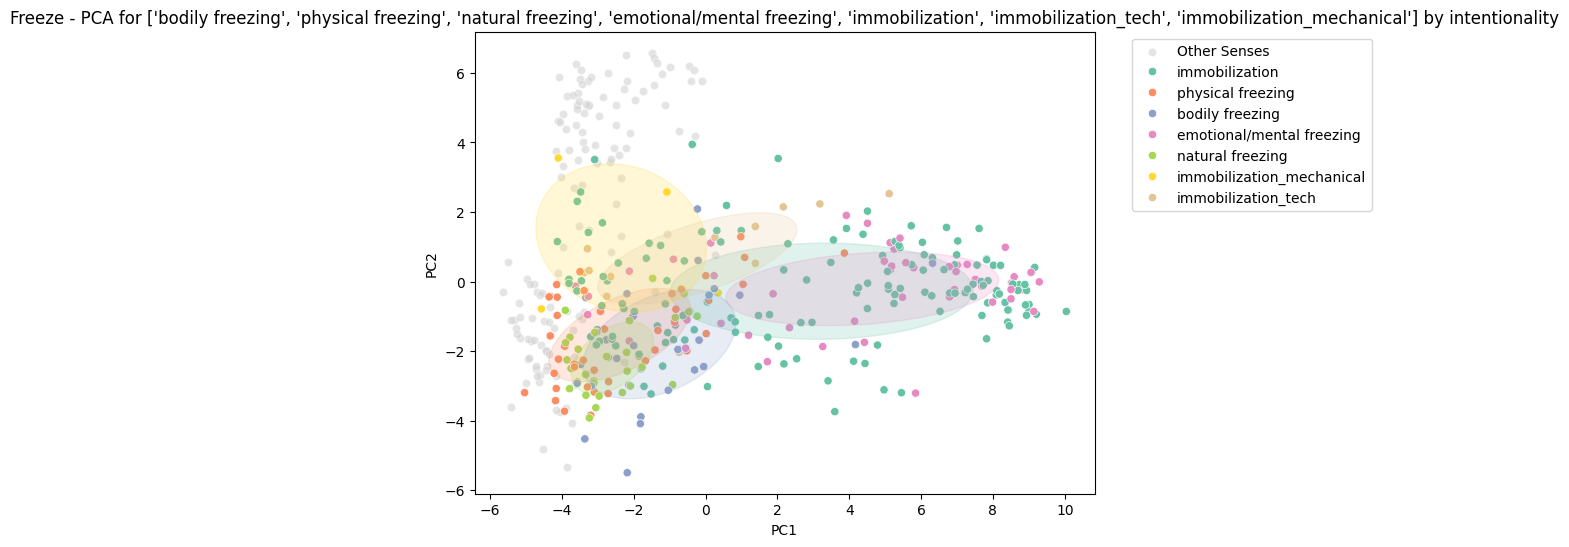

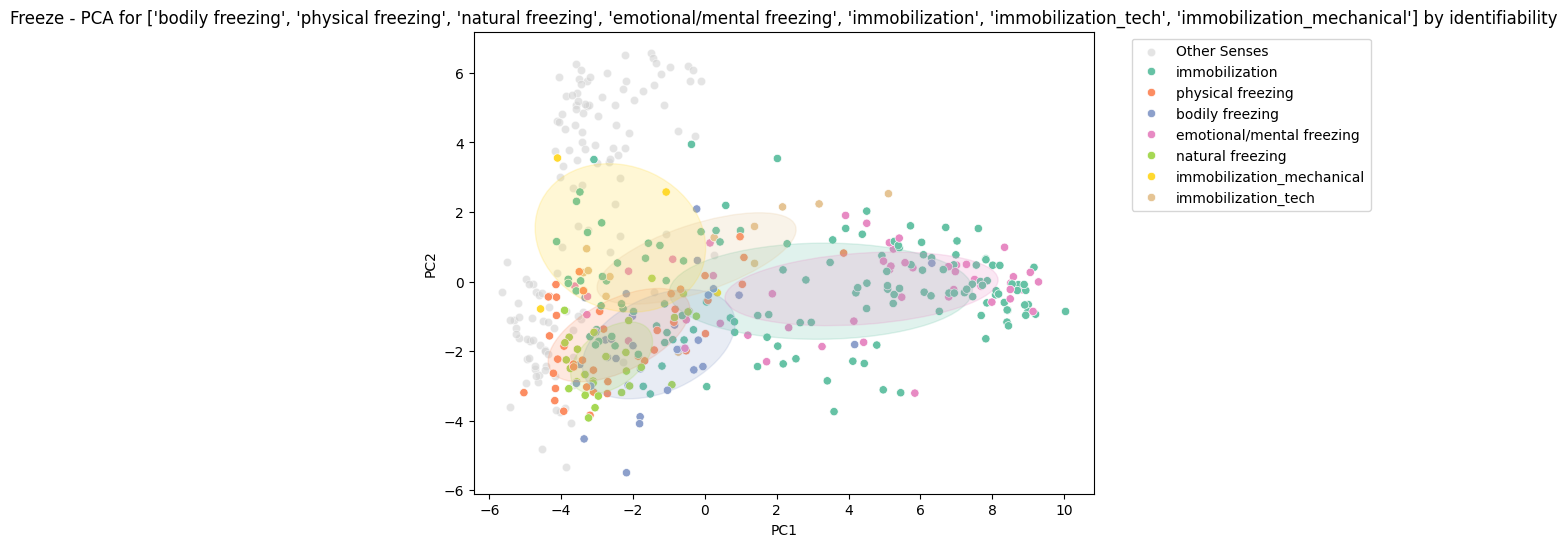

In [13]:
for sense_group in sense_groups:
    # Determine the verb based on the senses in the group
    if any(s in break_group_1 + break_group_2 + break_group_3 for s in sense_group):
        verb = "break"
    elif any(s in freeze_group_1 + freeze_group_2 for s in sense_group):
        verb = "freeze"
    else:
        verb = "unknown"

    if verb == "unknown":
        print(f"Skipping unknown verb group: {sense_group}")
        continue

    print(f"\n🔍 Analyzing verb: {verb}, senses: {sense_group}")
    sub_df = df[df['verb'] == verb].copy()

    # 임베딩만 추출
    X = sub_df.loc[:, '0':'767'].values
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X)
    sub_df['PC1'], sub_df['PC2'] = pca_result[:, 0], pca_result[:, 1]

    # break 동사의 경우 Caus가 왼쪽에, NCaus가 오른쪽에 오도록 PC1 축을 조정
    if verb == 'break':
        caus_mean_pc1 = sub_df[sub_df['syntax'] == 'Caus']['PC1'].mean()
        ncaus_mean_pc1 = sub_df[sub_df['syntax'] == 'NCaus']['PC1'].mean()
        if caus_mean_pc1 > ncaus_mean_pc1:
            sub_df['PC1'] = -sub_df['PC1']

    # === sense/syntax 대신 G~J 열 반복 ===
    for feature in features_to_plot:
        plt.figure(figsize=(8,6))

        # Plot non-highlighted senses in gray
        non_highlighted_df = sub_df[~sub_df['sense'].isin(sense_group)]
        sns.scatterplot(x='PC1', y='PC2', data=non_highlighted_df, color='lightgray', label='Other Senses', alpha=0.6)

        # Plot highlighted senses with color
        highlighted_df = sub_df[sub_df['sense'].isin(sense_group)]
        if not highlighted_df.empty:
            plot = sns.scatterplot(x='PC1', y='PC2', hue=highlighted_df['sense'], palette='Set2', data=highlighted_df)

            # Get the handles and labels from the legend
            handles, labels = plot.get_legend_handles_labels()

            # Create a dictionary to map labels to colors
            color_map = {}
            for label, handle in zip(labels, handles):
                 if hasattr(handle, 'get_facecolor'):
                    # Use the first color in the RGBA tuple
                    color_map[label] = handle.get_facecolor()[0][:3]
                 else:
                    color_map[label] = handle.get_color()

            # Add ellipses for highlighted senses
            for label in highlighted_df['sense'].unique():
                subset = highlighted_df[highlighted_df['sense'] == label]
                if len(subset) > 2:
                    cov = np.cov(subset[['PC1','PC2']].T)
                    eigvals, eigvecs = np.linalg.eigh(cov)
                    order = eigvals.argsort()[::-1]
                    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
                    angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
                    width, height = 2 * np.sqrt(eigvals)
                    ellipse = Ellipse((subset['PC1'].mean(), subset['PC2'].mean()),
                                      width, height, angle=angle, edgecolor=color_map.get(label), facecolor=color_map.get(label), alpha=0.2)
                    plt.gca().add_patch(ellipse)


        plt.title(f"{verb.capitalize()} - PCA for {sense_group} by {feature}")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

## Summary:

### Q&A
The user did not ask any questions.

### Data Analysis Key Findings
*   The analysis produced 15 PCA plots, visualizing the embeddings of the verbs "break" and "freeze".
*   For each verb, plots were created for predefined groups of senses, highlighting them with distinct colors and ellipses while showing other senses in light gray.
*   The visualizations were generated across three semantic features: "concreteness", "intentionality", and "identifiability".
*   To ensure consistent visual comparison for the verb "break", the PC1 axis was inverted so that causative senses always appeared on the left and non-causative senses on the right.

### Insights or Next Steps
*   The generated plots can be used to analyze the semantic relationships between different senses of a verb, observing how they cluster or separate in the embedding space.
*   Further analysis could involve quantitatively measuring the distance between sense clusters to formalize the observations from the visualizations.


In [16]:
from scipy.stats import ttest_ind, f_oneway
from statsmodels.multivariate.manova import MANOVA

for sense_group in sense_groups:
    if any(s in break_group_1 + break_group_2 + break_group_3 for s in sense_group):
        verb = "break"
    elif any(s in freeze_group_1 + freeze_group_2 for s in sense_group):
        verb = "freeze"
    else:
        verb = "unknown"

    if verb == "unknown":
        continue

    print(f"\n\n--- Analyzing Verb: {verb.upper()}, Senses: {sense_group} ---")

    sub_df = df[df['verb'] == verb].copy()

    # Perform PCA
    X = sub_df.loc[:, '0':'767'].values
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X)
    sub_df['PC1'], sub_df['PC2'] = pca_result[:, 0], pca_result[:, 1]

    # break 동사의 경우 Caus가 왼쪽에, NCaus가 오른쪽에 오도록 PC1 축을 조정
    if verb == 'break':
        caus_mean_pc1 = sub_df[sub_df['syntax'] == 'Caus']['PC1'].mean()
        ncaus_mean_pc1 = sub_df[sub_df['syntax'] == 'NCaus']['PC1'].mean()
        if caus_mean_pc1 > ncaus_mean_pc1:
            sub_df['PC1'] = -sub_df['PC1']

    highlighted_df = sub_df[sub_df['sense'].isin(sense_group)]

    # --- t-test/ANOVA for PC1 ---
    print("\n-- t-test/ANOVA for PC1 --")

    # Concreteness (t-test)
    concrete_pc1 = highlighted_df[highlighted_df['concreteness'] == 'Concrete']['PC1']
    abstract_pc1 = highlighted_df[highlighted_df['concreteness'] == 'Abstract']['PC1']
    if len(concrete_pc1) > 1 and len(abstract_pc1) > 1:
        stat, p_val = ttest_ind(concrete_pc1, abstract_pc1)
        print(f"Concreteness (t-test): p-value = {p_val:.4f}")
    else:
        print("Concreteness: Not enough data for t-test.")

    # Intentionality (ANOVA)
    intentionality_groups = [group['PC1'].values for name, group in highlighted_df.groupby('intentionality') if len(group) > 1]
    if len(intentionality_groups) > 1:
        stat, p_val = f_oneway(*intentionality_groups)
        print(f"Intentionality (ANOVA): p-value = {p_val:.4f}")
    else:
        print("Intentionality: Not enough data for ANOVA.")

    # Identifiability (ANOVA)
    identifiability_groups = [group['PC1'].values for name, group in highlighted_df.groupby('identifiability') if len(group) > 1]
    if len(identifiability_groups) > 1:
        stat, p_val = f_oneway(*identifiability_groups)
        print(f"Identifiability (ANOVA): p-value = {p_val:.4f}")
    else:
        print("Identifiability: Not enough data for ANOVA.")

    # --- MANOVA for PC1 and PC2 ---
    print("\n-- MANOVA for PC1 & PC2 --")

    # Concreteness
    if highlighted_df['concreteness'].nunique() > 1:
        manova = MANOVA.from_formula('PC1 + PC2 ~ concreteness', data=highlighted_df)
        print(manova.mv_test())
    else:
        print("Concreteness: Not enough data for MANOVA.")

    # Intentionality
    if highlighted_df['intentionality'].nunique() > 1:
        manova = MANOVA.from_formula('PC1 + PC2 ~ intentionality', data=highlighted_df)
        print(manova.mv_test())
    else:
        print("Intentionality: Not enough data for MANOVA.")

    # Identifiability
    if highlighted_df['identifiability'].nunique() > 1:
        manova = MANOVA.from_formula('PC1 + PC2 ~ identifiability', data=highlighted_df)
        print(manova.mv_test())
    else:
        print("Identifiability: Not enough data for MANOVA.")



--- Analyzing Verb: BREAK, Senses: ['emergence', 'disclosure'] ---

-- t-test/ANOVA for PC1 --
Concreteness (t-test): p-value = 0.0183
Intentionality (ANOVA): p-value = 0.0183
Identifiability (ANOVA): p-value = 0.0000

-- MANOVA for PC1 & PC2 --
                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.4199 2.0000 65.0000 44.9055 0.0000
         Pillai's trace 0.5801 2.0000 65.0000 44.9055 0.0000
 Hotelling-Lawley trace 1.3817 2.0000 65.0000 44.9055 0.0000
    Roy's greatest root 1.3817 2.0000 65.0000 44.9055 0.0000
------------------------------------------------------------
                                                            
------------------------------------------------------------
      concreteness      Value  Num DF 


🔍 Analyzing verb: break, senses: ['emergence', 'disclosure']


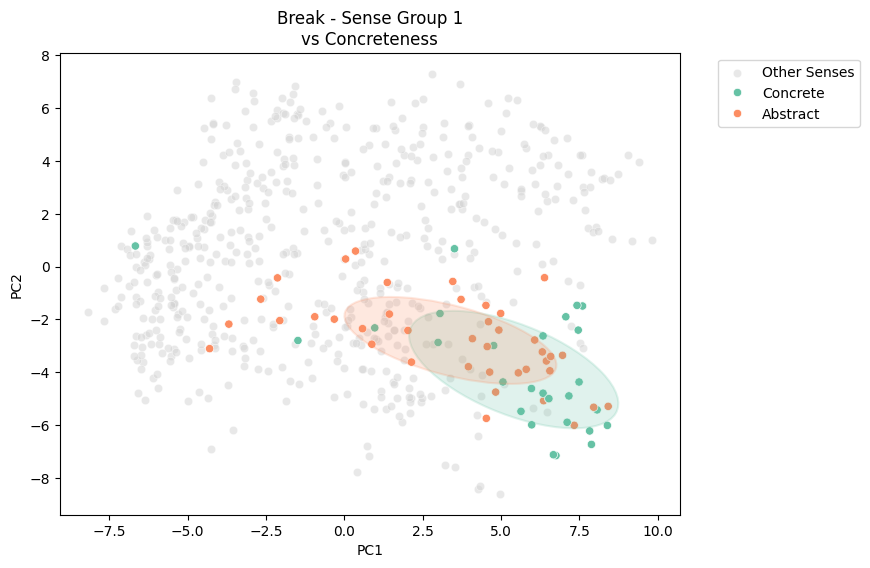

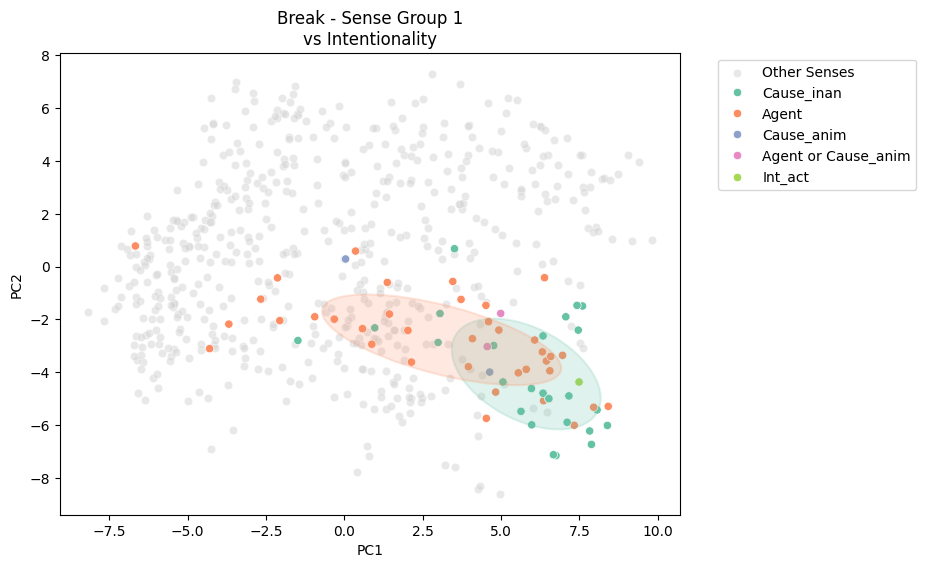

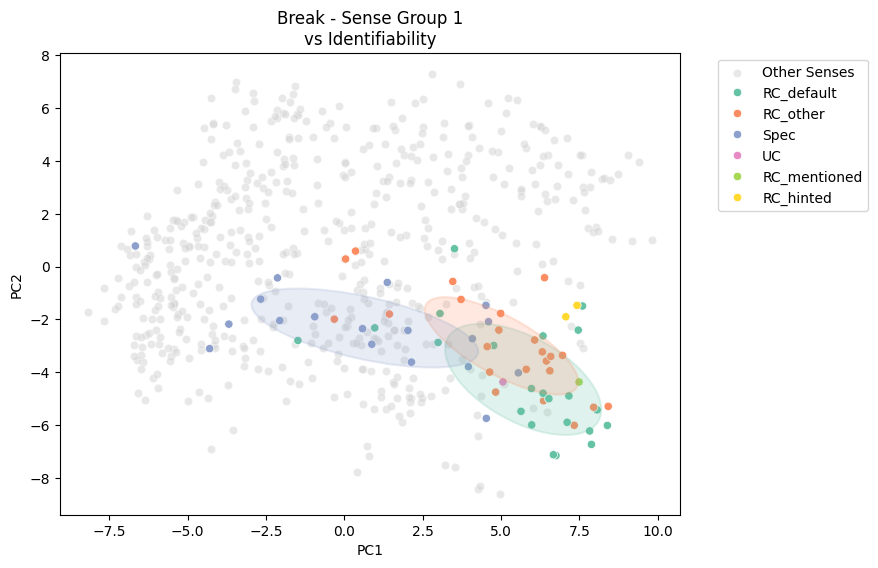


🔍 Analyzing verb: break, senses: ['decoding', 'breakthrough', 'interruption', 'termination', 'violation']


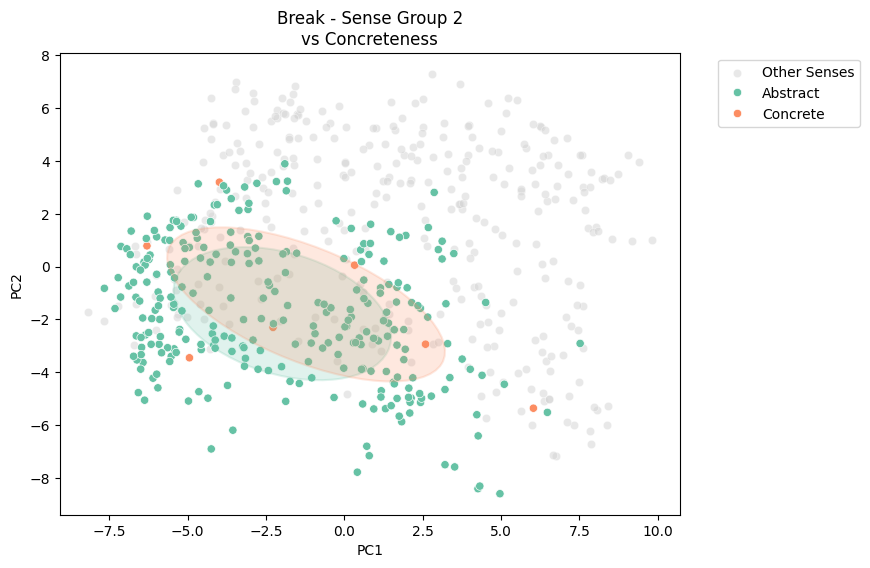

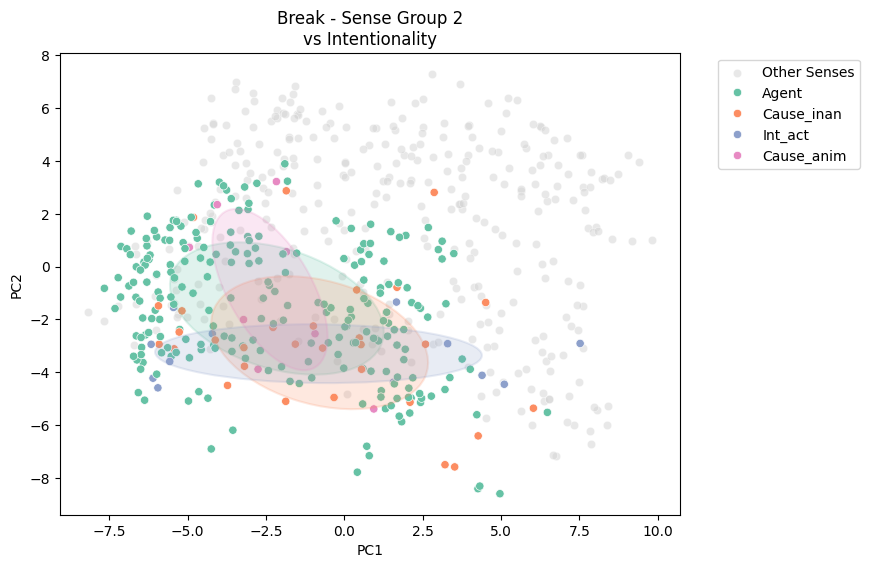

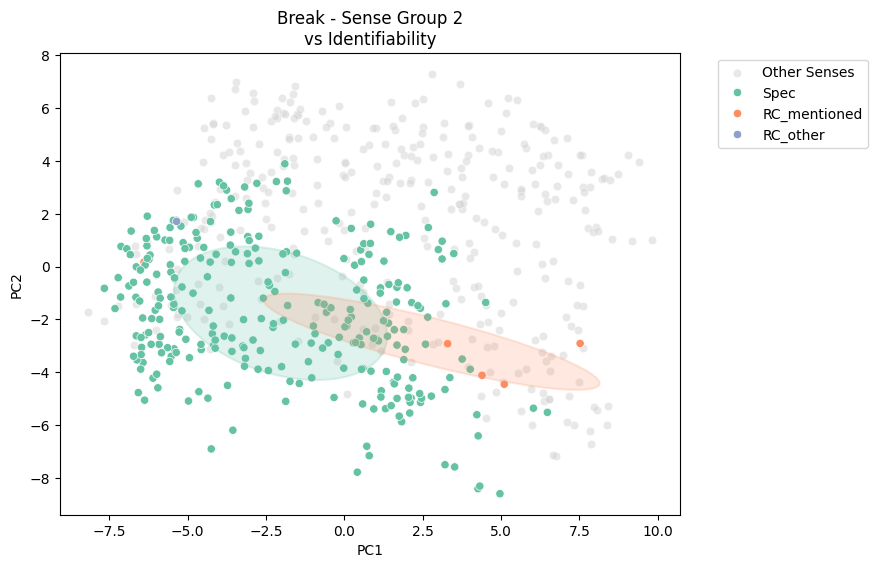


🔍 Analyzing verb: break, senses: ['bodily harm', 'destruction', 'EPS_breakdown', 'change']


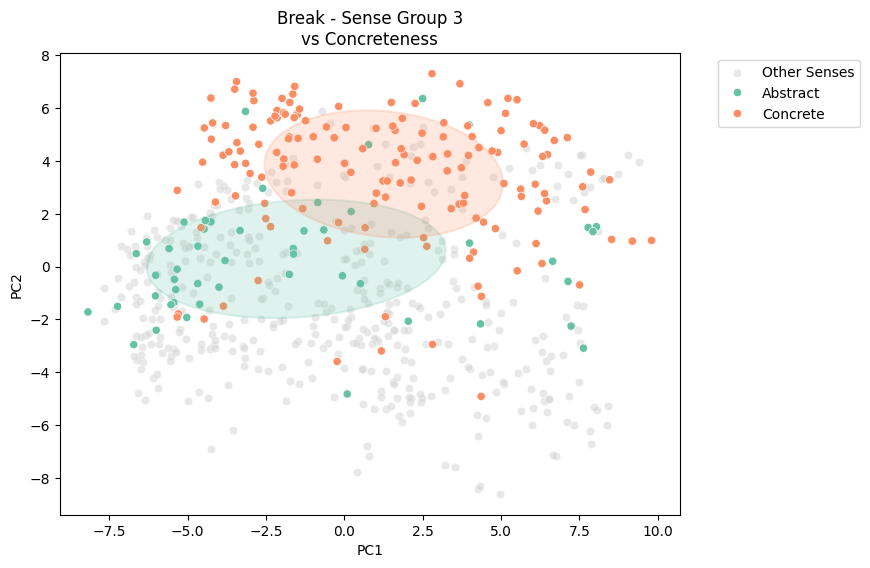

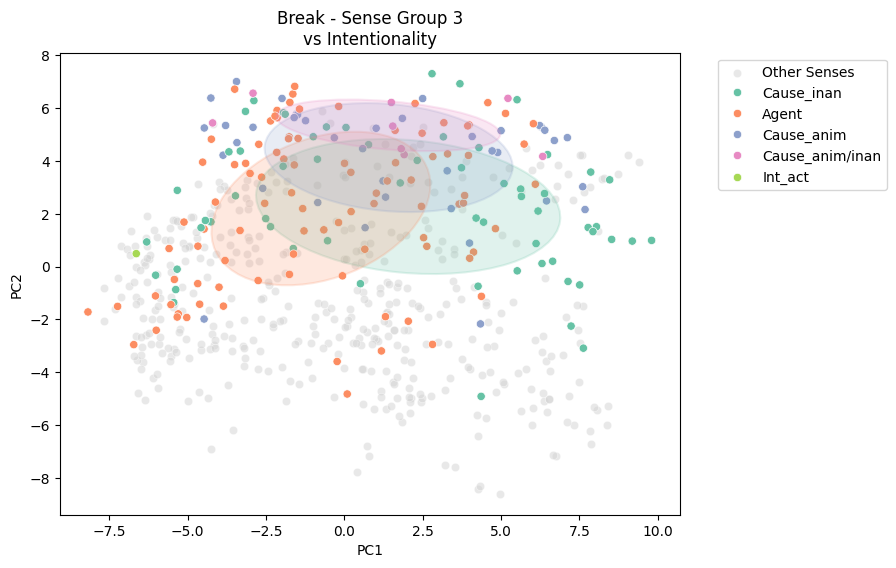

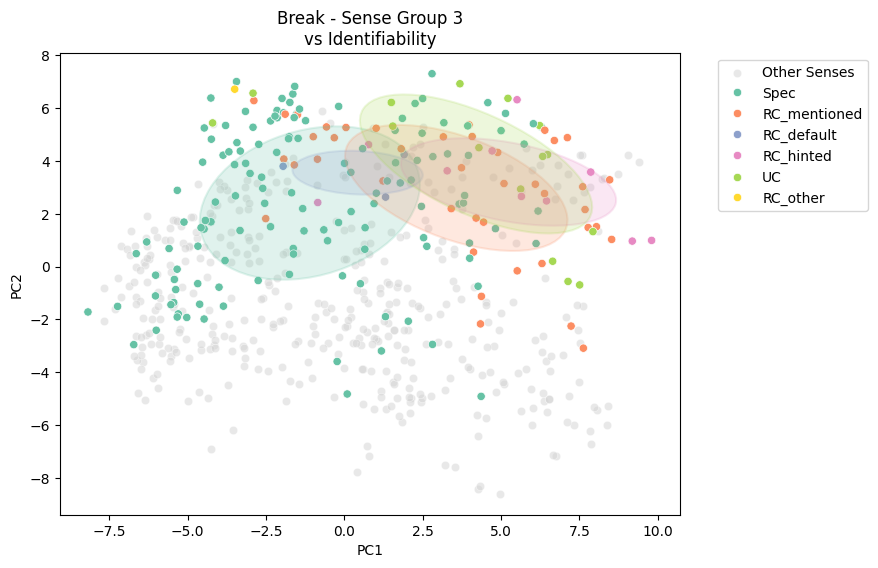


🔍 Analyzing verb: freeze, senses: ['preservation', 'economical freezing', 'suspension']


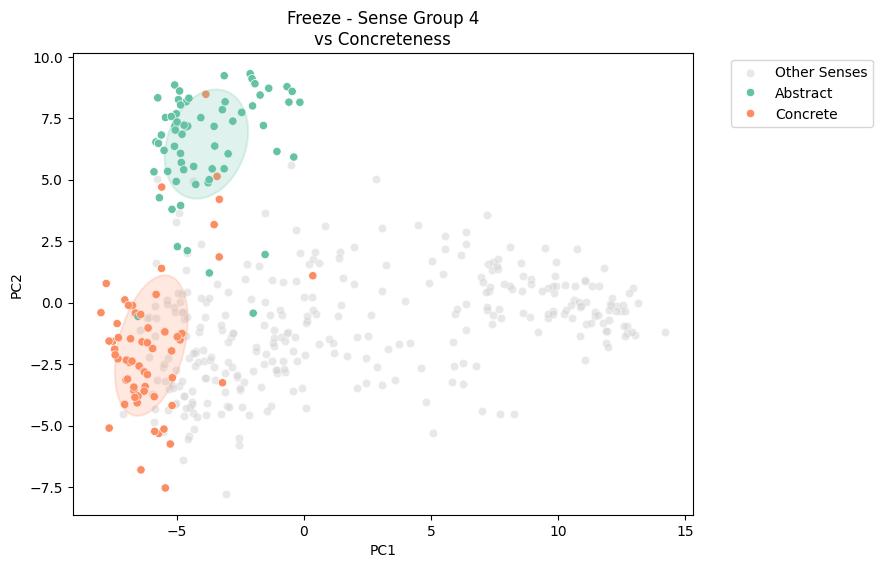

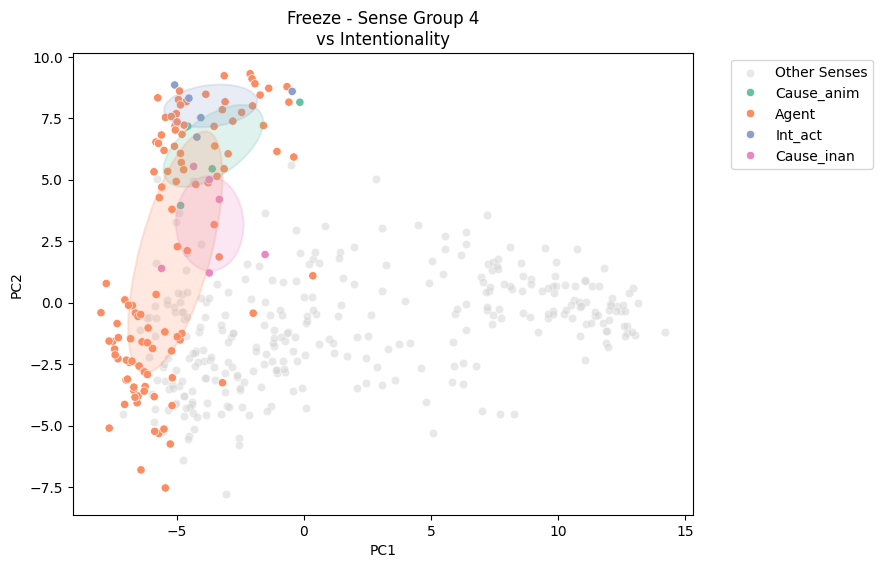

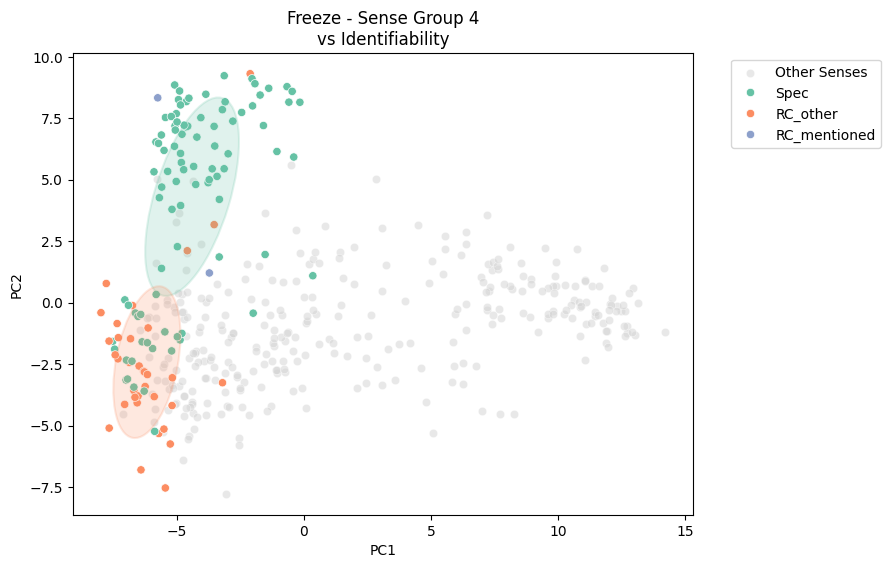


🔍 Analyzing verb: freeze, senses: ['bodily freezing', 'physical freezing', 'natural freezing', 'emotional/mental freezing', 'immobilization', 'immobilization_tech', 'immobilization_mechanical']


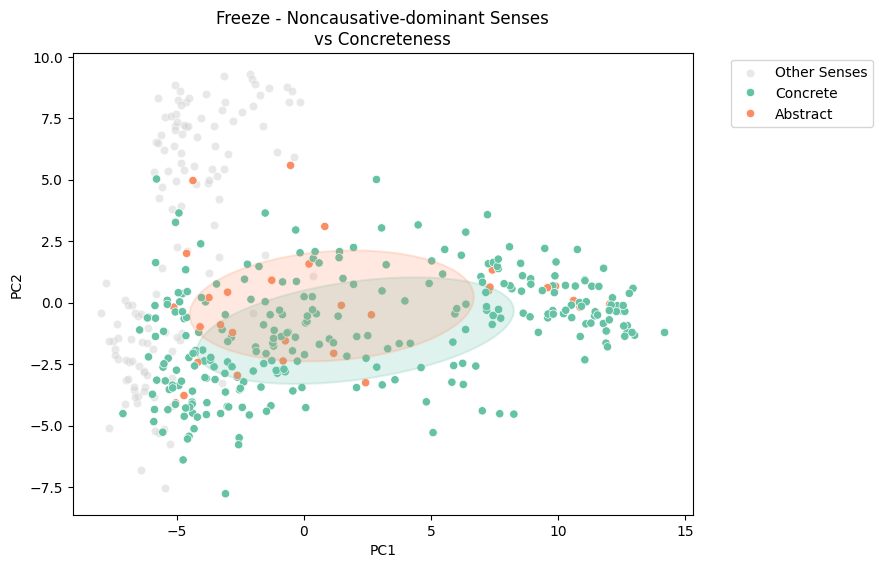

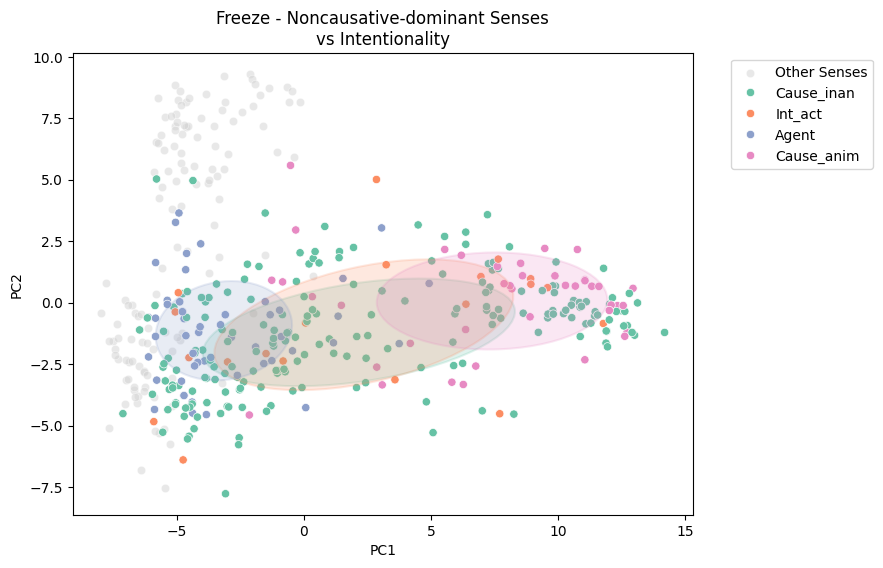

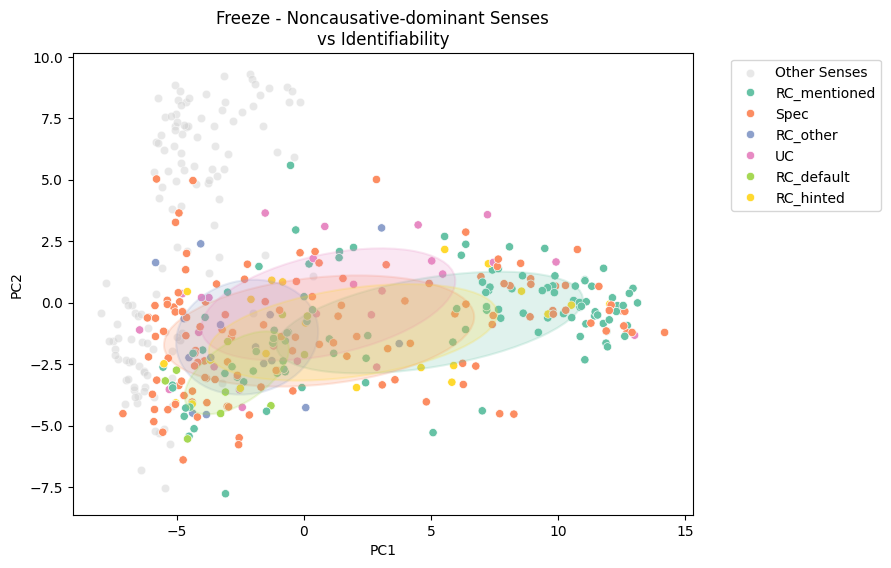

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pandas as pd # Ensure pandas is imported

# Load the saved embedding data
try:
    embedding_df_loaded = pd.read_csv("bert_embeddings_with_roles.csv")
except FileNotFoundError:
    print("Error: bert_embeddings_with_roles.csv not found. Please ensure the embedding extraction and saving step was successful.")
    # Exit or handle the error appropriately if the file is missing
    raise # Re-raise the exception to stop execution if the file is not found

# Merge the loaded embeddings with the original dataframe (assuming index alignment)
# Reset index of df to ensure alignment
df_reset = df.reset_index(drop=True)
# Drop the original embedding columns from embedding_df_loaded before merging if they exist
# Assuming columns '0' through '767' are the embeddings and the rest are metadata
embedding_cols = [str(i) for i in range(768)]
embedding_data_only = embedding_df_loaded[embedding_cols]

# Concatenate the embedding data with the original dataframe's metadata
# Aligning based on index after reset
merged_df = pd.concat([df_reset, embedding_data_only], axis=1)


for i, sense_group in enumerate(sense_groups): # Add enumerate to get the index
    # Determine the verb based on the senses in the group
    if any(s in break_group_1 + break_group_2 + break_group_3 for s in sense_group):
        verb = "break"
    elif any(s in freeze_group_1 + freeze_group_2 for s in sense_group):
        verb = "freeze"
    else:
        verb = "unknown"

    if verb == "unknown":
        print(f"Skipping unknown verb group: {sense_group}")
        continue

    print(f"\n🔍 Analyzing verb: {verb}, senses: {sense_group}")
    sub_df = merged_df[merged_df['verb'] == verb].copy()

    # 임베딩만 추출 (using the reloaded and merged data)
    X = sub_df.loc[:, embedding_cols].values # Use the list of embedding column names
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X)
    sub_df['PC1'], sub_df['PC2'] = pca_result[:, 0], pca_result[:, 1]

    # break 동사의 경우 Caus가 왼쪽에, NCaus가 오른쪽에 오도록 PC1 축을 조정
    if verb == 'break':
        caus_mean_pc1 = sub_df[sub_df['syntax'] == 'Caus']['PC1'].mean()
        ncaus_mean_pc1 = sub_df[sub_df['syntax'] == 'NCaus']['PC1'].mean()
        if caus_mean_pc1 > ncaus_mean_pc1:
            sub_df['PC1'] = -sub_df['PC1']

    # === sense/syntax 대신 G~J 열 반복 ===
    for feature in features_to_plot:
        plt.figure(figsize=(8,6))

        # Highlighted senses dataframe
        highlighted_df = sub_df[sub_df['sense'].isin(sense_group)].copy() # Use .copy() to avoid SettingWithCopyWarning
        # Non-highlighted senses dataframe
        non_highlighted_df = sub_df[~sub_df['sense'].isin(sense_group)].copy() # Use .copy()

        # Plot non-highlighted senses in gray
        sns.scatterplot(x='PC1', y='PC2', data=non_highlighted_df, color='lightgray', label='Other Senses', alpha=0.5)

        # Plot highlighted senses, colored by the feature
        if not highlighted_df.empty:
            # Exclude 'Caese_inan' specifically for the 'intentionality' feature in highlighted data
            if feature == 'intentionality':
                highlighted_df_filtered = highlighted_df[highlighted_df[feature] != 'Caese_inan'].copy()
            else:
                highlighted_df_filtered = highlighted_df.copy()

            if not highlighted_df_filtered.empty:
                 plot = sns.scatterplot(x='PC1', y='PC2', hue=feature, palette='Set2', data=highlighted_df_filtered)


                 # Get the handles and labels from the legend
                 handles, labels = plot.get_legend_handles_labels()

                 # Create a dictionary to map labels to colors
                 color_map = {}
                 # Filter out 'Other Senses' when creating the color map for ellipses
                 for label, handle in zip(labels, handles):
                     if label != 'Other Senses':
                         if hasattr(handle, 'get_facecolor'):
                            # Use the first color in the RGBA tuple
                            color_map[label] = handle.get_facecolor()[0][:3]
                         else:
                            color_map[label] = handle.get_color()

                 # Add ellipses for the feature groups within the highlighted senses
                 # Iterate over the unique values in the filtered highlighted data
                 for label in highlighted_df_filtered[feature].unique():
                     subset = highlighted_df_filtered[highlighted_df_filtered[feature] == label]
                     if len(subset) > 2:
                         cov = np.cov(subset[['PC1','PC2']].T)
                         eigvals, eigvecs = np.linalg.eigh(cov)
                         order = eigvals.argsort()[::-1]
                         eigvals, eigvecs = eigvals[order], eigvecs[:, order]
                         angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
                         width, height = 2 * np.sqrt(eigvals)
                         ellipse_color = color_map.get(label, 'black') # Default to black if label not in map
                         ellipse = Ellipse((subset['PC1'].mean(), subset['PC2'].mean()),
                                           width, height, angle=angle, edgecolor=ellipse_color, facecolor=ellipse_color, alpha=0.2, lw=1.5)
                         plt.gca().add_patch(ellipse)

        # Determine the title based on the sense group
        if sense_group == freeze_group_2:
            group_title = "Noncausative-dominant Senses"
        else:
            group_title = f"Sense Group {i+1}"


        # Modify the title to be on two lines, using the determined group title
        plt.title(f"{verb.capitalize()} - {group_title}\nvs {feature.capitalize()}")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()